# Homework Week 2
## Brandon Shurick

### HW2.0
> What is a race condition in the context of parallel computation? Give an example.  
> What is MapReduce?  
> How does it differ from Hadoop?  
> Which programming paradigm is Hadoop based on? Explain and give a simple example in code and show the code running.  

A race condition is what can result from two parallel tasks which originate from the same application but are not properly synchronized, so that the order in which the tasks finish in determines the final result. For example, if you write an application which divides the result of some improperly synchronized process by itself plus another value and loads it back to the original variable, the number that you divide may be different depending on if the threads finish near the same time or if one thread reads the result of another in sequence. 

MapReduce is a framework that can process large datasets in parallel across multiple nodes. 

The Hadoop core framework is a combination of the MapReduce framework plus a distributed file system called Hadoop File System (HDFS). 

Hadoop is based on the Functional Programming paradigm, where a function (map) is first applied to each value in the dataset, the data is sorted by key, and then another function (reduce / fold) is applied to all of the values for each key. 

Code example below:

In [1]:
import re
from itertools import groupby
def mapper(line):
    ''' Map function outputs 
        all words for each spam document
    '''
    line = re.sub(r'[^\t\sa-z]+',' ',line.lower())
    words = re.findall(r'[a-z]+',line)
    return('\n'.join('{}\t{}'.format(w,1) for w in words))

def reducer(g):
    ''' Aggregate grouped words
        into counts 
    '''
    sums = 0
    for kv in g:
        k,v = kv.split('\t')
        sums += int(v)
    return('{}\t{}'.format(k,sums))
    
def run(): 
    ''' Run functional programming steps (mapper, sort, reducer)
        Print all word counts from spam file 
    '''
    lines = '\n'.join(mapper(l) for l in open('enronemail_1h.txt','r').readlines() if mapper(l))
    words = sorted(lines.split('\n'))
    print('\n'.join(reducer(g) for k,g in groupby(words)))

run()

a	543
ab	5
abidjan	2
ability	2
able	14
abn	1
about	52
above	11
absent	1
absenteeism	1
absolute	2
absolutely	1
absorb	1
abuse	2
abused	1
acce	1
accelerate	1
accelerated	1
accept	3
acceptable	1
accepted	1
accepting	2
accepts	1
access	12
accomodate	4
accomodates	1
accompanied	1
according	2
accordingly	1
account	36
accountability	1
accounting	5
accounts	1
accrual	2
accurate	1
aches	1
achieve	1
achieved	1
acid	1
acquire	1
acquisition	1
acrobaat	1
acrobat	1
across	10
act	7
action	1
activate	4
active	1
activists	1
activities	10
actor	1
actress	1
actual	4
actually	2
ad	31
adage	1
adams	1
adapted	1
add	12
added	2
adding	2
addition	5
additional	13
additionally	2
address	27
addressed	1
addresses	5
addressing	1
addtional	1
adequately	1
adhesion	1
adm	1
admin	1
adminder	2
administration	3
admitted	1
admixture	1
adobe	12
adobee	1
adolescent	1
adr	1
adrianbold	2
ads	5
adult	3
adv	1
advance	4
advanced	1
advantage	1
advantages	1
advertise	2
advertised	1
advertisement	4
advertisements	1
advertising	7
ad

### HW2.1 Sort in Hadoop MapReduce
> Given as input: Records of the form (integer, “NA”), where integer is any integer, and “NA” is just the empty string.  
> Output: sorted key value pairs of the form (integer, “NA”) in decreasing order; what happens if you have multiple reducers? Do you need additional steps? Explain.  

> Write code to generate N  random records of the form (integer, “NA”). Let N = 10,000.  
> Write the python Hadoop streaming map-reduce job to perform this sort. Display the top 10 biggest numbers. Display the 10 smallest numbers  

In [50]:
!mkdir input
!rmdir output

mkdir: input: File exists
rmdir: output: Directory not empty


In [51]:
from __future__ import print_function
import random
def generate_file(N,fname='input/randomrecords.txt'):
    ''' Function to generate random integers '''
    gen_number = lambda n: random.randint(0,n-1)
    nums = '\n'.join('<{},"{}">'.format(gen_number(N),'NA') for n in range(N))
    w = open(fname,'w')
    print(nums,file=w)
    w.close()
generate_file(10000)

In [52]:
!head -n2 input/randomrecords.txt

<5800,"NA">
<4106,"NA">


In [53]:
%%writefile mapper.py
#!/usr/bin/env python
import re, sys
def mapper(line):
    ''' Mapper function for Hadoop '''
    line = re.sub(r'[<>\"]','',line.strip())
    num,word = line.split(',')
    print '{}\t{}'.format(word,num)

for line in sys.stdin:
    mapper(line)

Overwriting mapper.py


In [54]:
%%writefile reducer.py
#!/usr/bin/env python
import sys
priorkey = None
values = []

def printkey(values):
    print 'Key: '+key
    print '\nBottom 10:'
    print '\n'.join(str(s) for s in sorted(values)[:10])
    print '\nTop 10:'
    print '\n'.join(str(s) for s in sorted(values,reverse=True)[:10])

for line in sys.stdin:
    ''' Reducer '''
    key,val = line.strip().split('\t')
    
    if key==priorkey or priorkey is None:
        values.append(int(val))
    else:
        printkey(values)
        values = []
    priorkey = key

# Last line 
printkey(values)

Overwriting reducer.py


In [55]:
!chmod +x mapper.py && chmod +x reducer.py

In [58]:
!rm -Rf output
!hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar -input ./input/randomrecords.txt -mapper ./mapper.py -reducer ./reducer.py -output ./output 

16/01/26 12:37:54 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/01/26 12:37:54 INFO Configuration.deprecation: session.id is deprecated. Instead, use dfs.metrics.session-id
16/01/26 12:37:54 INFO jvm.JvmMetrics: Initializing JVM Metrics with processName=JobTracker, sessionId=
16/01/26 12:37:54 INFO jvm.JvmMetrics: Cannot initialize JVM Metrics with processName=JobTracker, sessionId= - already initialized
16/01/26 12:37:55 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/26 12:37:55 INFO mapreduce.JobSubmitter: number of splits:1
16/01/26 12:37:55 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local1306983771_0001
16/01/26 12:37:55 INFO mapreduce.Job: The url to track the job: http://localhost:8080/
16/01/26 12:37:55 INFO mapred.LocalJobRunner: OutputCommitter set in config null
16/01/26 12:37:55 INFO mapreduce.Job: Running job: job_local1306983771_0001
16/01/26 12:37:5

In [61]:
!cat output/* 

Key: NA	
	
Bottom 10:	
0	
0	
1	
1	
1	
3	
4	
4	
7	
7	
	
Top 10:	
9998	
9997	
9997	
9997	
9996	
9994	
9994	
9994	
9993	
9992	


### HW2.2.  WORDCOUNT
>Using the Enron data from HW1 and Hadoop MapReduce streaming, write the mapper/reducer job that  will determine the word count (number of occurrences) of each white-space delimitted token (assume spaces, fullstops, comma as delimiters). Examine the word “assistance” and report its word count results.
> 
>CROSSCHECK: >grep assistance enronemail_1h.txt|cut -d$'\t' -f4| grep assistance|wc -l    
>       8    
>       NOTE  "assistance" occurs on 8 lines but how many times does the token occur? 10 times! This is the number we ?are looking for!




In [72]:
%%writefile mapper.py
#!/usr/bin/env python
import re, sys
def mapper(line):
    ''' Map function for wordcount in Hadoop
    '''
    line = re.sub(r'[^\t\sa-z]+',' ',line.lower())
    words = re.findall(r'[a-z]+',line)
    print '\n'.join('{}\t{}'.format(w,1) for w in words)

for line in sys.stdin:
    mapper(line)

Overwriting mapper.py


In [106]:
%%writefile reducer.py
#!/usr/bin/env python
import sys 

sums = 0
prev_sums = 0
prev_k = None
for line in sys.stdin:
    k,v = line.strip().split('\t')
    if k==prev_k or prev_k is None:
        sums += int(v)
    else:
        print '{}\t{}'.format(prev_k,prev_sums)
        sums = 0
        sums += int(v)
    prev_k = k
    prev_sums = sums

# Last line
print '{}\t{}'.format(k,sums)

Overwriting reducer.py


In [64]:
!chmod +x mapper.py && chmod +x reducer.py

In [107]:
!rm -Rf ./output
!hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar -input ./enronemail_1h.txt -mapper ./mapper.py -reducer ./reducer.py -output ./output 

16/01/26 12:57:46 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/01/26 12:57:46 INFO Configuration.deprecation: session.id is deprecated. Instead, use dfs.metrics.session-id
16/01/26 12:57:46 INFO jvm.JvmMetrics: Initializing JVM Metrics with processName=JobTracker, sessionId=
16/01/26 12:57:46 INFO jvm.JvmMetrics: Cannot initialize JVM Metrics with processName=JobTracker, sessionId= - already initialized
16/01/26 12:57:47 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/26 12:57:47 INFO mapreduce.JobSubmitter: number of splits:1
16/01/26 12:57:47 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local1324263943_0001
16/01/26 12:57:47 INFO mapreduce.Job: The url to track the job: http://localhost:8080/
16/01/26 12:57:47 INFO mapred.LocalJobRunner: OutputCommitter set in config null
16/01/26 12:57:47 INFO mapred.LocalJobRunner: OutputCommitter is org.apache.hadoop.mapred.Fi

In [108]:
!cat ./output/* | grep assistance

assistance	10


#### HW2.2.1
>Using Hadoop MapReduce and your wordcount job (from HW2.2) determine the top-10 occurring tokens (most frequent tokens)

In [109]:
%%writefile reducer.py
#!/usr/bin/env python
import sys 

i = 0

for line in sys.stdin:
    if i<10:
        print line.strip()
        i+=1

Overwriting reducer.py


In [110]:
!chmod +x reducer.py

In [111]:
!rm -Rf output2 
!hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator -D stream.map.output.field.separator='\t' -D stream.num.map.output.key.fields=2 -D mapreduce.partition.keycomparator.options=-k2,2nr -D mapreduce.job.reduces=1 -mapper /bin/cat -reducer reducer.py -input ./output -output ./output2 

16/01/26 12:58:07 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/01/26 12:58:07 INFO Configuration.deprecation: session.id is deprecated. Instead, use dfs.metrics.session-id
16/01/26 12:58:07 INFO jvm.JvmMetrics: Initializing JVM Metrics with processName=JobTracker, sessionId=
16/01/26 12:58:07 INFO jvm.JvmMetrics: Cannot initialize JVM Metrics with processName=JobTracker, sessionId= - already initialized
16/01/26 12:58:08 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/26 12:58:08 INFO mapreduce.JobSubmitter: number of splits:1
16/01/26 12:58:08 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local303351566_0001
16/01/26 12:58:08 INFO mapreduce.Job: The url to track the job: http://localhost:8080/
16/01/26 12:58:08 INFO mapred.LocalJobRunner: OutputCommitter set in config null
16/01/26 12:58:08 INFO mapred.LocalJobRunner: OutputCommitter is org.apache.hadoop.mapred.Fil

In [112]:
!cat output2/*

the	1247
to	964
and	686
of	566
a	543
you	445
in	418
your	395
ect	382
for	374


### HW2.3. Multinomial NAIVE BAYES with NO Smoothing
>Using the Enron data from HW1 and Hadoop MapReduce, write  a mapper/reducer job(s) that
>   will both learn  Naive Bayes classifier and classify the Enron email messages using the learnt Naive Bayes classifier. Use all white-space delimitted tokens as independent input variables (assume spaces, fullstops, commas as delimiters). Note: for multinomial Naive Bayes, the Pr(X=“assistance”|Y=SPAM) is calculated as follows:
>
>   the number of times “assistance” occurs in SPAM labeled documents / the number of words in documents labeled SPAM 
>
>   E.g.,   “assistance” occurs 5 times in all of the documents Labeled SPAM, and the length in terms of the number of words in all documents labeled as SPAM (when concatenated) is 1,000. Then Pr(X=“assistance”|Y=SPAM) = 5/1000. Note this is a multinomial estimation of the class conditional for a Naive Bayes Classifier. No smoothing is needed in this HW. Multiplying lots of probabilities, which are between 0 and 1, can result in floating-point underflow. Since log(xy) = log(x) + log(y), it is better to perform all computations by summing logs of probabilities rather than multiplying probabilities. Please pay attention to probabilites that are zero! They will need special attention. Count up how many times you need to process a zero probabilty for each class and report. 
>
>   Report the performance of your learnt classifier in terms of misclassifcation error rate of your multinomial Naive Bayes Classifier. Plot a histogram of the  posterior probabilities (i.e., Pr(Class|Doc)) for each class over the training set. Summarize what you see. 
>
>   Error Rate = misclassification rate with respect to a provided set (say training set in this case). It is more formally defined here:
>
>Let DF represent the evalution set in the following:
>Err(Model, DF) = |{(X, c(X)) ∈ DF : c(X) != Model(x)}|   / |DF|
>
>Where || denotes set cardinality; c(X) denotes the class of the tuple X in DF; and Model(X) denotes the class inferred by the Model “Model”

In [113]:
%%writefile agg_files.sh
#!/usr/bin/env bash
## Compile all data into one training file ## 
hams=`ls enron1-training-data-raw/ham/*`
spams=`ls enron1-training-data-raw/spam/*`
rm train_data.txt
for h in ${hams[@]}
do
    echo -e "$h\t0\t`cat $h | tr '\n' ' ' | tr '\r' ' '`" >> train_data.txt
done
for s in ${spams[@]}
do
    echo -e "$s\t1\t`cat $s | tr '\n' ' ' | tr '\r' ' '`" >> train_data.txt
done

Overwriting agg_files.sh


In [ ]:
!chmod +x agg_files.sh
!./agg_files.sh

In [52]:
%%writefile mapper.py
#!/usr/bin/env python
import re, sys
WORDS = re.compile(r'[\w]+')
for line in sys.stdin:
    ## Read lines from data chunk ##
    # Remove non-word, non-whitespace characters
    components = line.strip().split('\t')
    if components[0]=='*': 
        print line
        continue 
    spamdoc = int(components[1])
    words = ' '.join(components[2:])
    words = re.sub(r'[^a-z\s\t]+',' ',words.lower())
    
    ## Compile list of words ##
    wordslist = WORDS.findall(words)
    vocab = set(wordslist)
    
    ## Count total words in document ##
    totalwords = len(wordslist)
    
    ## Find words based on user input ##
    for word in vocab:
        word_cnt = len([ w for w in wordslist if w==word ])
        # Send results for each inputted word to reducer
        print('K{}\t{}\t{}\t{}'.format(components[0],word,word_cnt,spamdoc))

Overwriting mapper.py


In [53]:
%%writefile reducer.py
#!/usr/bin/env python
import sys
import math

docs = 0
typecnt = {}
prior = {}
findwords = {}
totalwords = {}

prev_cid = None
for line in sys.stdin:  
    ## Read in lines from Mapper ##
    line = line.strip()
    components = line.split('\t')
    cid,word,word_cnt,spamdoc = components

    if spamdoc not in findwords: 
        wordcnt = {}
        wordcnt[word] = int(word_cnt)
        findwords[spamdoc] = wordcnt
    else: 
        wordcnt = findwords[spamdoc]
        if word not in wordcnt:
            wordcnt[word] = int(word_cnt)
        else:
            wordcnt[word] += int(word_cnt)
        findwords[spamdoc] = wordcnt

    if prev_cid!=cid:
        docs += 1

        # Count of class 
        if spamdoc not in typecnt: typecnt[spamdoc] = 1
        else: typecnt[spamdoc] += 1
    
    prev_cid = cid

findwords_spam = '~'.join('{}:{}'.format(w,findwords['1'][w]) for w in findwords['1'])
findwords_ham = '~'.join('{}:{}'.format(w,findwords['0'][w]) for w in findwords['0'])
out = '*\tdocs^{}'.format(docs)
out += '%spamdocs^{}'.format(typecnt['1'])
out += '%hamdocs^{}'.format(typecnt['0'])
out += '%findwords_spam^{}'.format(findwords_spam)
out += '%findwords_ham^{}'.format(findwords_ham)
print out

Overwriting reducer.py


In [54]:
%%writefile reducer2.py
#!/usr/bin/env python
import sys, math 
''' Make a second pass through the data
    Read in lines from Mapper 
    (i.e. 'cat' from previous output) 
'''
docs = 0
spamdocs = 0
hamdocs = 0
totalwords_spam = 0
totalwords_ham = 0
prior_spam = 0
prior_ham = 0
spam_prob = 0
ham_prob = 0

findwords_spam = {}
findwords_ham = {}
doccnts = {}

prev_cid = None 

for line in sys.stdin:
    line = line.strip()
    components = line.split('\t')
    cid = components[0]
    if cid == '*':
        d,s,h,fs,fh = components[1].split('%')
        docs = int(d.split('^')[1])
        spamdocs = int(s.split('^')[1])
        hamdocs = int(h.split('^')[1])
        
        findwords_spam = { x.split(':')[0]:int(x.split(':')[1]) \
                        for x in fs.split('^')[1].split('~') }
        findwords_ham = { x.split(':')[0]:int(x.split(':')[1])  \
                        for x in fh.split('^')[1].split('~') }
        
        totalwords_spam = sum(findwords_spam[w] for w in findwords_spam)
        totalwords_ham = sum(findwords_ham[w] for w in findwords_ham)
        
        prior_spam = (spamdocs*1.0) / docs
        prior_ham = (hamdocs*1.0) / docs
    elif cid == '':
        continue
    else:
        cid, word, word_cnt, spam = components
        if prev_cid!=cid and prev_cid is not None:
            spam_prob = math.log(prior_spam)
            ham_prob = math.log(prior_ham)
            
            for w in doccnts:
                if findwords_spam.get(w,0)>0:
                    spam_prob += math.log((findwords_spam.get(w,0)*1.0) / (totalwords_spam))*math.log(doccnts[w])
                if findwords_ham.get(w,0)>0:
                    ham_prob += math.log((findwords_ham.get(w,0)*1.0) / (totalwords_ham))*math.log(doccnts[w])
            
            doccnts = {}
            
            if spam_prob>ham_prob: 
                print '{}\t{}\t{}\t{}\t{}'.format(cid,1,spam,math.e**spam_prob,math.e**ham_prob)
            else:
                print '{}\t{}\t{}\t{}\t{}'.format(cid,0,spam,math.e**spam_prob,math.e**ham_prob)
        
        if word not in doccnts:
            doccnts[word] = int(word_cnt)
        else:
            doccnts[word] += int(word_cnt)
        prev_cid = cid 

## Last line 
spam_prob = math.log(prior_spam)
ham_prob = math.log(prior_ham)

for w in doccnts:
    if findwords_spam.get(w,0)>0:
        spam_prob += math.log((findwords_spam.get(w,0)*1.0) / (totalwords_spam))*math.log(doccnts[w])
    if findwords_ham.get(w,0)>0:
        ham_prob += math.log((findwords_ham.get(w,0)*1.0) / (totalwords_ham))*math.log(doccnts[w])

doccnts = {}

if spam_prob>ham_prob: 
    print '{}\t{}\t{}\t{}\t{}'.format(cid,1,spam,math.e**spam_prob,math.e**ham_prob)
else:
    print '{}\t{}\t{}\t{}\t{}'.format(cid,0,spam,math.e**spam_prob,math.e**ham_prob)

Overwriting reducer2.py


In [55]:
!chmod +x mapper.py && chmod +x reducer.py && chmod +x reducer2.py

In [56]:
!rm -Rf ./output && rm -Rf ./output2
!hadoop jar /usr/local/Cellar/hadoop/2.7.0/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.0.jar -input ./train_data.txt -mapper ./mapper.py -reducer ./reducer.py -output ./output 
!cat ./output/* > test_data.txt
!cat ./enronemail_1h.txt >> test_data.txt
!hadoop jar /usr/local/Cellar/hadoop/2.7.0/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.0.jar -input ./test_data.txt -mapper ./mapper.py -reducer ./reducer2.py -output ./output2 

16/01/26 10:04:17 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/01/26 10:04:17 INFO Configuration.deprecation: session.id is deprecated. Instead, use dfs.metrics.session-id
16/01/26 10:04:17 INFO jvm.JvmMetrics: Initializing JVM Metrics with processName=JobTracker, sessionId=
16/01/26 10:04:17 INFO jvm.JvmMetrics: Cannot initialize JVM Metrics with processName=JobTracker, sessionId= - already initialized
16/01/26 10:04:17 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/26 10:04:17 INFO mapreduce.JobSubmitter: number of splits:1
16/01/26 10:04:17 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local372317233_0001
16/01/26 10:04:17 INFO mapreduce.Job: The url to track the job: http://localhost:8080/
16/01/26 10:04:17 INFO mapred.LocalJobRunner: OutputCommitter set in config null
16/01/26 10:04:17 INFO mapreduce.Job: Running job: job_local372317233_0001
16/01/26 10:04:17 

In [57]:
!cat ./output2/*
!cat ./output2/* | awk -F'\t' '{if ($2!=$3) {errors+=1;} total+=1; \
                            }END{ print "Error: ",(errors)*100/total,"%" }'
!cat output2/* > results_23.txt

K0001.1999-12-10.kaminski	0	0	0.290023201856	0.709976798144
K0001.2000-01-17.beck	0	0	0.290023201856	0.709976798144
K0001.2000-06-06.lokay	0	0	6.70140492137e-286	3.81695346508e-274
K0001.2001-02-07.kitchen	1	0	0.0	0.0
K0001.2001-04-02.williams	0	0	1.03833694159e-15	1.92734467667e-12
K0002.1999-12-13.farmer	0	0	6.86683238048e-121	8.51438636562e-118
K0002.2001-02-07.kitchen	0	0	1.67149506758e-193	1.22116737778e-169
K0002.2001-05-25.SA_and_HP	0	1	5.59791991941e-15	1.18625461063e-14
K0002.2003-12-18.GP	0	1	2.40175947244e-19	6.97009430299e-19
K0002.2004-08-01.BG	0	1	2.80355941464e-78	6.73574688998e-73
K0003.1999-12-10.kaminski	0	0	1.76197062059e-62	1.10719670739e-60
K0003.1999-12-14.farmer	0	0	1.19827566766e-25	2.64225719501e-22
K0003.2000-01-17.beck	0	0	5.06911035349e-10	5.81689858483e-09
K0003.2001-02-08.kitchen	0	0	4.78395234639e-102	2.27254812502e-84
K0003.2003-12-18.GP	0	1	2.37378770426e-105	2.09412874381e-93
K0003.2004-08-01.BG	1	1	8.17810889618e-51	8.48387779403e-53
K0004.1999-12-10.

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np
import math
%matplotlib inline  
data = pd.read_csv('results_23.txt',sep='\t',header=None)
data.columns = ['id','prediction','spam_ind','spam_prob','ham_prob']
data['spam_prob_log'] = np.log(data['spam_prob'])
data['ham_prob_log'] = np.log(data['ham_prob'])
data = data.replace([np.inf, -np.inf], np.nan)

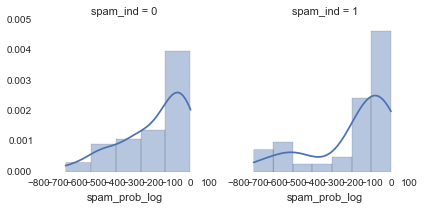

In [28]:
g = sns.FacetGrid(data[['spam_prob_log','spam_ind']].dropna(), col="spam_ind")
g = g.map(sns.distplot, 'spam_prob_log')

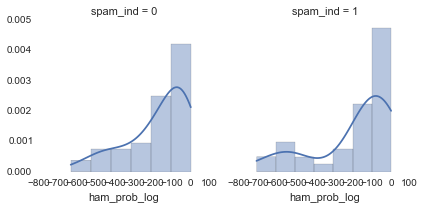

In [29]:
g = sns.FacetGrid(data[['ham_prob_log','spam_ind']].dropna(), col="spam_ind")
g = g.map(sns.distplot, 'ham_prob_log')

In [30]:
print('Zero probability count: {}'.format(np.sum(np.isnan(data['spam_prob_log']))))

Zero probability count: 10


### HW2.4 
> Repeat HW2.3 with the following modification: use Laplace plus-one smoothing. Compare the misclassifcation error rates for 2.3 versus 2.4 and explain the differences.

> For a quick reference on the construction of the Multinomial NAIVE BAYES classifier that you will code,
please consult the "Document Classification" section of the following wikipedia page:

>https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Document_classification

>OR the original paper by the curators of the Enron email data:

>http://www.aueb.gr/users/ion/docs/ceas2006_paper.pdf

In [48]:
%%writefile reducer2.py
#!/usr/bin/env python
import sys, math 
''' Make a second pass through the data
    Read in lines from Mapper 
    (i.e. 'cat' from previous output) 
'''
docs = 0
spamdocs = 0
hamdocs = 0
totalwords_spam = 0
totalwords_ham = 0
prior_spam = 0
prior_ham = 0
spam_prob = 0
ham_prob = 0

findwords_spam = {}
findwords_ham = {}
doccnts = {}

prev_cid = None 

for line in sys.stdin:
    line = line.strip()
    components = line.split('\t')
    cid = components[0]
    if cid == '*':
        d,s,h,fs,fh = components[1].split('%')
        docs = int(d.split('^')[1])
        spamdocs = int(s.split('^')[1])
        hamdocs = int(h.split('^')[1])
        
        findwords_spam = { x.split(':')[0]:int(x.split(':')[1]) \
                        for x in fs.split('^')[1].split('~') }
        findwords_ham = { x.split(':')[0]:int(x.split(':')[1])  \
                        for x in fh.split('^')[1].split('~') }
        
        totalwords_spam = sum(findwords_spam[w] for w in findwords_spam)
        totalwords_ham = sum(findwords_ham[w] for w in findwords_ham)
        
        prior_spam = (spamdocs*1.0) / docs
        prior_ham = (hamdocs*1.0) / docs
    elif cid == '':
        continue
    else:
        cid, word, word_cnt, spam = components
        if prev_cid!=cid and prev_cid is not None:
            spam_prob = math.log(prior_spam)
            ham_prob = math.log(prior_ham)
            
            for w in doccnts:
                spam_prob += math.log((1+findwords_spam.get(w,0)*1.0) / (totalwords_spam+len(doccnts)))*math.log(doccnts[w])
                ham_prob += math.log((1+findwords_ham.get(w,0)*1.0) / (totalwords_ham+len(doccnts)))*math.log(doccnts[w])
            
            doccnts = {}
            
            if spam_prob>ham_prob: 
                print '{}\t{}\t{}\t{}\t{}'.format(cid,1,spam,math.e**spam_prob,math.e**ham_prob)
            else:
                print '{}\t{}\t{}\t{}\t{}'.format(cid,0,spam,math.e**spam_prob,math.e**ham_prob)
        else:        
            if word not in doccnts:
                doccnts[word] = int(word_cnt)
            else:
                doccnts[word] += int(word_cnt)
        prev_cid = cid 

## Last line 
spam_prob = math.log(prior_spam)
ham_prob = math.log(prior_ham)

for w in doccnts:
    spam_prob += math.log((1+findwords_spam.get(w,0)*1.0) / (totalwords_spam+len(doccnts)))*math.log(doccnts[w])
    ham_prob += math.log((1+findwords_ham.get(w,0)*1.0) / (totalwords_ham+len(doccnts)))*math.log(doccnts[w])

doccnts = {}

if spam_prob>ham_prob: 
    print '{}\t{}\t{}\t{}\t{}'.format(cid,1,spam,math.e**spam_prob,math.e**ham_prob)
else:
    print '{}\t{}\t{}\t{}\t{}'.format(cid,0,spam,math.e**spam_prob,math.e**ham_prob)

Overwriting reducer2.py


In [49]:
!rm -Rf ./output && rm -Rf ./output2
!hadoop jar /usr/local/Cellar/hadoop/2.7.0/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.0.jar -input ./train_data.txt -mapper ./mapper.py -reducer ./reducer.py -output ./output 
!cat ./output/* > test_data.txt
!cat ./enronemail_1h.txt >> test_data.txt
!hadoop jar /usr/local/Cellar/hadoop/2.7.0/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.0.jar -input ./test_data.txt -mapper ./mapper.py -reducer ./reducer2.py -output ./output2 

16/01/26 10:02:54 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/01/26 10:02:54 INFO Configuration.deprecation: session.id is deprecated. Instead, use dfs.metrics.session-id
16/01/26 10:02:54 INFO jvm.JvmMetrics: Initializing JVM Metrics with processName=JobTracker, sessionId=
16/01/26 10:02:54 INFO jvm.JvmMetrics: Cannot initialize JVM Metrics with processName=JobTracker, sessionId= - already initialized
16/01/26 10:02:54 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/26 10:02:54 INFO mapreduce.JobSubmitter: number of splits:1
16/01/26 10:02:55 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local2111712745_0001
16/01/26 10:02:55 INFO mapreduce.Job: The url to track the job: http://localhost:8080/
16/01/26 10:02:55 INFO mapred.LocalJobRunner: OutputCommitter set in config null
16/01/26 10:02:55 INFO mapreduce.Job: Running job: job_local2111712745_0001
16/01/26 10:02:5

In [50]:
!cat ./output2/*
!cat ./output2/* | awk -F'\t' '{if ($2==$3) {corrects+=1;} total+=1; \
                            }END{ print "Error: ",(total-corrects)*100/total,"%" }'
!cat ./output2/* > results_24.txt

K0001.1999-12-10.kaminski	0	0	0.290023201856	0.709976798144
K0001.2000-01-17.beck	0	0	0.290023201856	0.709976798144
K0001.2000-06-06.lokay	0	0	0.0	5.95466421177e-282
K0001.2001-02-07.kitchen	0	0	0.0	0.0
K0001.2001-04-02.williams	0	0	1.3445702724e-15	1.95196756626e-12
K0002.1999-12-13.farmer	0	0	9.27084913562e-118	1.77474544524e-114
K0002.2001-02-07.kitchen	0	0	2.95646469743e-219	2.11667616032e-169
K0002.2001-05-25.SA_and_HP	0	1	5.87497295995e-15	1.24355982767e-14
K0002.2003-12-18.GP	0	1	2.4233054474e-19	7.00108758012e-19
K0002.2004-08-01.BG	1	1	7.86523669389e-78	1.56832394485e-82
K0003.1999-12-10.kaminski	0	0	5.76445966994e-68	4.20589009224e-66
K0003.1999-12-14.farmer	0	0	6.44741209455e-29	4.80617613688e-26
K0003.2000-01-17.beck	0	0	8.47466614713e-10	1.59484856778e-06
K0003.2001-02-08.kitchen	0	0	9.23837493529e-102	2.29246337306e-81
K0003.2003-12-18.GP	0	1	1.08550015307e-115	6.09611731158e-91
K0003.2004-08-01.BG	1	1	1.08588305501e-50	1.11058716571e-52
K0004.1999-12-10.kaminski	1	0	9.34

In [36]:
data = pd.read_csv('results_24.txt',sep='\t',header=None)
data.columns = ['id','prediction','spam_ind','spam_prob','ham_prob']
data['spam_prob_log'] = np.log(data['spam_prob'])
data['ham_prob_log'] = np.log(data['ham_prob'])
data = data.replace([np.inf, -np.inf], np.nan)

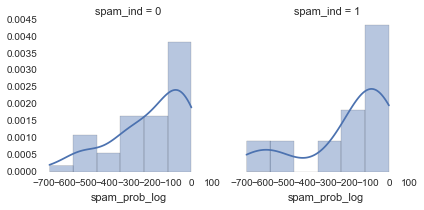

In [37]:
g = sns.FacetGrid(data[['spam_prob_log','spam_ind']].dropna(), col="spam_ind")
g = g.map(sns.distplot, 'spam_prob_log')

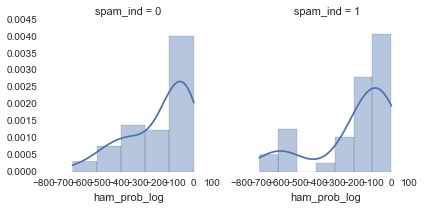

In [38]:
g = sns.FacetGrid(data[['ham_prob_log','spam_ind']].dropna(), col="spam_ind")
g = g.map(sns.distplot, 'ham_prob_log')

In [39]:
print('Zero probability count: {}'.format(np.sum(np.isnan(data['spam_prob_log']))))

Zero probability count: 12


Laplace smoothing reduces my error rate because now words that are missing from the vocabulary contribute a small, near-zero probability, rather than completely ignori

### HW2.5. 
>Repeat HW2.4. This time when modeling and classification ignore tokens with a frequency of less than three (3) in the training set. How does it affect the misclassifcation error of learnt naive multinomial Bayesian Classifier on the training dataset:


In [40]:
%%writefile reducer2.py
#!/usr/bin/env python
import sys, math 
''' Make a second pass through the data
    Read in lines from Mapper 
    (i.e. 'cat' from previous output) 
'''
docs = 0
spamdocs = 0
hamdocs = 0
totalwords_spam = 0
totalwords_ham = 0
prior_spam = 0
prior_ham = 0
spam_prob = 0
ham_prob = 0

findwords_spam = {}
findwords_ham = {}
doccnts = {}

prev_cid = None 

for line in sys.stdin:
    line = line.strip()
    components = line.split('\t')
    cid = components[0]
    if cid == '*':
        d,s,h,fs,fh = components[1].split('%')
        docs = int(d.split('^')[1])
        spamdocs = int(s.split('^')[1])
        hamdocs = int(h.split('^')[1])
        
        findwords_spam = { x.split(':')[0]:int(x.split(':')[1]) \
                        for x in fs.split('^')[1].split('~') 
                         if int(x.split(':')[1]) >= 3}
        findwords_ham = { x.split(':')[0]:int(x.split(':')[1])  \
                        for x in fh.split('^')[1].split('~') 
                          if int(x.split(':')[1]) >= 3}
        
        totalwords_spam = sum(findwords_spam[w] for w in findwords_spam)
        totalwords_ham = sum(findwords_ham[w] for w in findwords_ham)
        
        prior_spam = (spamdocs*1.0) / docs
        prior_ham = (hamdocs*1.0) / docs
    elif cid == '':
        continue
    else:
        cid, word, word_cnt, spam = components
        if prev_cid!=cid and prev_cid is not None:
            spam_prob = math.log(prior_spam)
            ham_prob = math.log(prior_ham)
            
            for w in doccnts:
                spam_prob += math.log((1+findwords_spam.get(w,0)*1.0) / (totalwords_spam+len(doccnts)))*math.log(doccnts[w])
                ham_prob += math.log((1+findwords_ham.get(w,0)*1.0) / (totalwords_ham+len(doccnts)))*math.log(doccnts[w])
            
            doccnts = {}
            
            if spam_prob>ham_prob: 
                print '{}\t{}\t{}\t{}\t{}'.format(cid,1,spam,math.e**spam_prob,math.e**ham_prob)
            else:
                print '{}\t{}\t{}\t{}\t{}'.format(cid,0,spam,math.e**spam_prob,math.e**ham_prob)
        else:        
            if word not in doccnts:
                doccnts[word] = int(word_cnt)
            else:
                doccnts[word] += int(word_cnt)
        prev_cid = cid 

## Last line 
spam_prob = math.log(prior_spam)
ham_prob = math.log(prior_ham)

for w in doccnts:
    spam_prob += math.log((1+findwords_spam.get(w,0)*1.0) / (totalwords_spam+len(doccnts)))*math.log(doccnts[w])
    ham_prob += math.log((1+findwords_ham.get(w,0)*1.0) / (totalwords_ham+len(doccnts)))*math.log(doccnts[w])

doccnts = {}

if spam_prob>ham_prob: 
    print '{}\t{}\t{}\t{}\t{}'.format(cid,1,spam,math.e**spam_prob,math.e**ham_prob)
else:
    print '{}\t{}\t{}\t{}\t{}'.format(cid,0,spam,math.e**spam_prob,math.e**ham_prob)

Overwriting reducer2.py


In [41]:
!rm -Rf ./output && rm -Rf ./output2
!hadoop jar /usr/local/Cellar/hadoop/2.7.0/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.0.jar -input ./train_data.txt -mapper ./mapper.py -reducer ./reducer.py -output ./output 
!cat ./output/* > test_data.txt
!cat ./enronemail_1h.txt >> test_data.txt
!hadoop jar /usr/local/Cellar/hadoop/2.7.0/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.0.jar -input ./test_data.txt -mapper ./mapper.py -reducer ./reducer2.py -output ./output2 

16/01/26 02:46:17 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/01/26 02:46:17 INFO Configuration.deprecation: session.id is deprecated. Instead, use dfs.metrics.session-id
16/01/26 02:46:17 INFO jvm.JvmMetrics: Initializing JVM Metrics with processName=JobTracker, sessionId=
16/01/26 02:46:17 INFO jvm.JvmMetrics: Cannot initialize JVM Metrics with processName=JobTracker, sessionId= - already initialized
16/01/26 02:46:18 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/26 02:46:18 INFO mapreduce.JobSubmitter: number of splits:1
16/01/26 02:46:18 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local995719994_0001
16/01/26 02:46:18 INFO mapreduce.Job: The url to track the job: http://localhost:8080/
16/01/26 02:46:18 INFO mapred.LocalJobRunner: OutputCommitter set in config null
16/01/26 02:46:18 INFO mapreduce.Job: Running job: job_local995719994_0001
16/01/26 02:46:18 

In [42]:
!cat ./output2/*
!cat ./output2/* | awk -F'\t' '{if ($2==$3) {corrects+=1;} total+=1; \
                            }END{ print "Error: ",(total-corrects)*100/total,"%" }'
!cat ./output2/* > results_25.txt

K0001.1999-12-10.kaminski	0	0	0.290023201856	0.709976798144
K0001.2000-01-17.beck	0	0	0.290023201856	0.709976798144
K0001.2000-06-06.lokay	0	0	0.0	5.37740576109e-282
K0001.2001-02-07.kitchen	0	0	0.0	0.0
K0001.2001-04-02.williams	0	0	2.32086865032e-15	2.12558968043e-12
K0002.1999-12-13.farmer	0	0	1.28235538835e-115	2.66911803269e-114
K0002.2001-02-07.kitchen	0	0	1.31488668405e-217	8.1173599011e-169
K0002.2001-05-25.SA_and_HP	0	1	1.40301649009e-14	1.42457016208e-14
K0002.2003-12-18.GP	0	1	7.51821056193e-19	8.35460507769e-19
K0002.2004-08-01.BG	1	1	1.35270664897e-76	1.05352942114e-82
K0003.1999-12-10.kaminski	0	0	1.92510657663e-66	2.10067336031e-66
K0003.1999-12-14.farmer	0	0	3.81923735654e-29	1.72395388322e-26
K0003.2000-01-17.beck	0	0	7.02791152431e-10	1.66954983022e-06
K0003.2001-02-08.kitchen	0	0	5.74629108756e-100	4.7091461135e-81
K0003.2003-12-18.GP	0	1	3.07574208321e-114	8.06160443854e-91
K0003.2004-08-01.BG	1	1	1.14381112718e-49	1.60396237833e-52
K0004.1999-12-10.kaminski	1	0	3.52

The error rate is reduced by a small amount by ignoring words with lower frequency counts. 

### HW2.6 
>Benchmark your code with the Python SciKit-Learn implementation of the multinomial Naive Bayes algorithm

>It always a good idea to benchmark your solutions against publicly available libraries such as SciKit-Learn, The Machine Learning toolkit available in Python. In this exercise, we benchmark ourselves against the SciKit-Learn implementation of multinomial Naive Bayes.  For more information on this implementation see: http://scikit-learn.org/stable/modules/naive_bayes.html more  

>In this exercise, please complete the following:

>— Run the Multinomial Naive Bayes algorithm (using default settings) from SciKit-Learn over the same training data used in HW2.5 and report the misclassification error (please note some data preparation might be needed to get the Multinomial Naive Bayes algorithm from SkiKit-Learn to run over this dataset)
- Prepare a table to present your results, where rows correspond to approach used (SkiKit-Learn versus your Hadoop implementation) and the column presents the training misclassification error
— Explain/justify any differences in terms of training error rates over the dataset in HW2.5 between your Multinomial Naive Bayes implementation (in Map Reduce) versus the Multinomial Naive Bayes implementation in SciKit-Learn 

>Which approach to Naive Bayes would you recommend for SPAM detection? Justify your selection.

In [43]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Read data
train_data = pd.read_csv('train_data.txt',sep='\t',header=None)
train_data.columns = ['id','spam','header_message']

test_data = pd.read_csv('enronemail_1h.txt',sep='\t',header=None)
test_data.columns = ['id','spam','header','message']
test_data['header_message'] = test_data['header'].fillna('') +' '+ test_data['message'].fillna('')

# Build sparse vector matrix 
cv = CountVectorizer()
X = cv.fit_transform(train_data['header_message'])
Y = np.array(train_data['spam'].ravel())
             
# Fit NB model
nb = MultinomialNB()
nb.fit(X, Y)

# Test accuracy 
X = cv.transform(test_data['header_message'])
Y = np.array(test_data['spam'].ravel())
p = nb.predict(X)
accuracy_rate = np.mean(p == Y)
print('Accuracy: {}%'.format(accuracy_rate*100))

Accuracy: 98.0%


<table align='left'>
<tr> 
    <th>Approach</th>
    <th>Error Rate</th>
</tr>
<tr> 
    <td>Map-Reduce</td>
    <td>34%</td>
</tr>
<tr> 
    <td>Sklearn</td>
    <td>2%</td>
</tr>
</table>

I would recommend the Sklearn approach, which beats the error rate from the map-reduce classifier.